<a href="https://colab.research.google.com/github/DmitryKostin/yandex-praktikum-data-analyst/blob/main/06_app_metrics_project/app_metrics_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ бизнес-показателей приложения Procrastinate Pro+

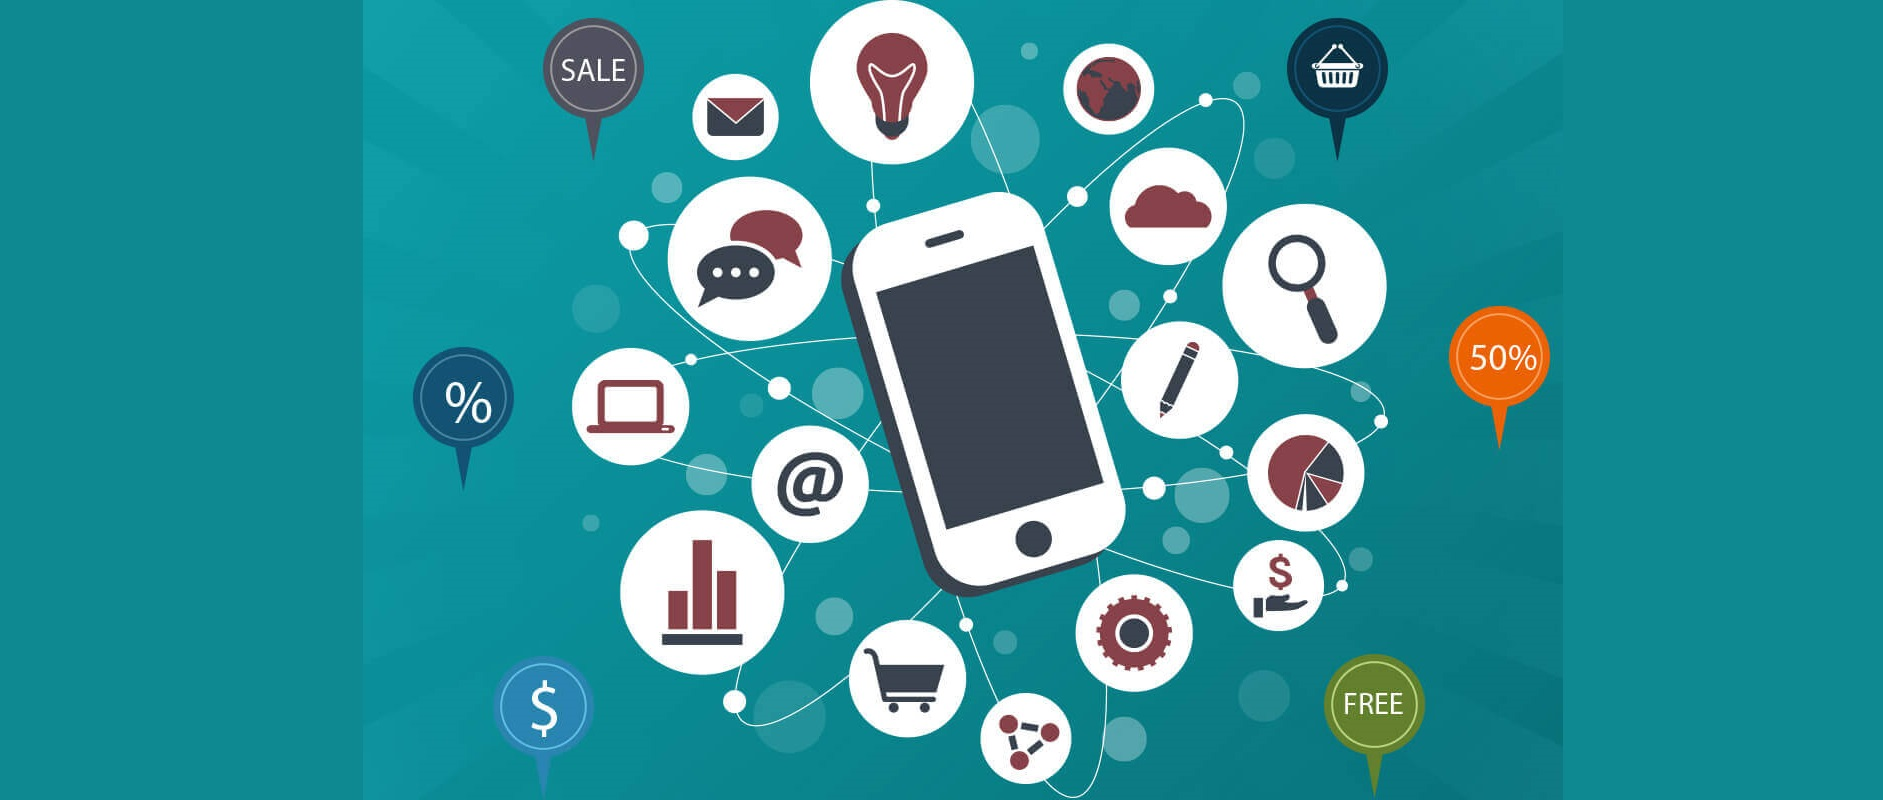

**Содержание** <a class='anchor' id='table_of_contents'></a>

* [Описание проекта](#description)
* [Описание данных](#data)
* [Шаг 1. Загрузка данных и подготовка их к анализу](#step_1)
* [Шаг 2. Функции для расчёта и анализа LTV, ROI, удержания и конверсии](#step_2)
* [Шаг 3. Исследовательский анализ данных](#step_3)
* [Шаг 4. Маркетинговый анализ](#step_4)
* [Шаг 5. Анализ окупаемости рекламы](#step_5)
* [Выводы](#final)

## Описание проекта <a class='anchor' id='description'></a>

В проекте проводится маркетинговый и продуктовый анализ развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

## Описание данных <a class='anchor' id='data'></a>

Имеются три датасета: 
- `visits_info_short.csv` — хранит лог сервера с информацией о посещениях сайта, 
- `orders_info_short.csv` — информация о заказах, 
- `costs_info_short.csv` — информация о расходах на рекламу.

Структура `visits_info_short.csv`:
- `User Id` — уникальный идентификатор пользователя,
- `Region` — страна пользователя,
- `Device` — тип устройства пользователя,
- `Channel` — идентификатор источника перехода,
- `Session Start` — дата и время начала сессии,
- `Session End` — дата и время окончания сессии.

Структура `orders_info_short.csv`:
- `User Id` — уникальный идентификатор пользователя,
- `Event Dt` — дата и время покупки,
- `Revenue` — сумма заказа.

Структура `costs_info_short.csv`:
- `dt` — дата проведения рекламной кампании,
- `Channel` — идентификатор рекламного источника,
- `costs` — расходы на эту кампанию.

[Назад к содержанию](#table_of_contents)

## Шаг 1. Загрузка данных и подготовка их к анализу <a class='anchor' id='step_1'></a>

Загрузим необходимые для анализа библиотеки и дополнительные функции.

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# функция для подсчета дубликатов и получения общих сведений о датасете
def get_info(data):
    display(data.head())
    print()
    print('Число дубликатов:', data.duplicated().sum())
    print()
    data.info()

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

Изучим данные и выполним предобработку.

In [3]:
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

In [4]:
get_info(visits)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
get_info(orders)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
get_info(costs)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [7]:
# переведем названия столбцов в нижний регистр
visits.columns = [i.lower() for i in visits.columns]
visits = visits.rename(columns={'user id': 'user_id', 
                                'session start': 'session_start',
                                'session end': 'session_end'})

orders.columns = [i.lower() for i in orders.columns]
orders = orders.rename(columns={'user id':'user_id',
                                'event dt':'event_dt'})

costs.columns = [i.lower() for i in costs.columns]

In [8]:
# преобразуем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Изучим данные на предмет пропусков и дубликатов.

In [9]:
pd.DataFrame({'visits':[visits.isna().sum().sum(),
                        visits.duplicated().sum()],
              'orders':[orders.isna().sum().sum(),
                        orders.duplicated().sum()],
              'costs':[costs.isna().sum().sum(),
                       costs.duplicated().sum()]},
              index=['Пропуски', 'Дубликаты'])

,visits,orders,costs
Пропуски,0,0,0
Дубликаты,0,0,0


Пропусков и дубликатов во всех трех датасетах нет.

[Назад к содержанию](#table_of_contents)

## Шаг 2. Функции для расчёта и анализа LTV, ROI, удержания и конверсии <a class='anchor' id='step_2'></a>

Загрузим функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Загрузим функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [10]:
def get_profiles(sessions, orders, ad_costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [12]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [13]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [14]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [15]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [16]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [17]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

[Назад к содержанию](#table_of_contents)

## Шаг 3. Исследовательский анализ данных <a class='anchor' id='step_3'></a>

1. Составим профили пользователей с помощью фукнции `get_profiles`. Определим минимальную и максимальную даты привлечения пользователей.

In [18]:
profiles = get_profiles(visits, orders, costs)

In [19]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [20]:
print('Минимальная дата привлечения пользователей:', profiles['dt'].min())
print('Максимальная дата привлечения пользователей:', profiles['dt'].max())

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Исходя из данных профилей, пользователи привлекались с 1 мая 2019 г. по 27 октября 2019 г.

2. Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны. Отсортируем датафрейм по доле платящих пользователей (`ratio`) по убыванию.

In [21]:
(profiles
 .pivot_table(index='region', values='payer', aggfunc=['sum', 'count', 'mean'])
 .reset_index()
 .rename(columns={'sum':'payers', 'count':'total_users', 'mean':'ratio'})
 .droplevel(1, axis=1)
 .sort_values(by='ratio', ascending=False)
 .style.format({'ratio':'{:.2%}'})
)

,region,payers,total_users,ratio
3,United States,6902,100002,6.90%
1,Germany,616,14981,4.11%
2,UK,700,17575,3.98%
0,France,663,17450,3.80%


Наибольшая доля платящих пользователей наблюдается из США - 6,9%. В США также находится наибольшее суммарное количество пользователей - 100 002. 
Германия, Великобритания и Франция имеют доля платящих пользователей на уровне  3,8-4,1%.

3. Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства. Отсортируем датафрейм по доле платящих пользователей (`ratio`) по убыванию.

In [22]:
(profiles
 .pivot_table(index='device', values='payer', aggfunc=['sum', 'count', 'mean'])
 .reset_index()
 .rename(columns={'sum':'payers', 'count':'total_users', 'mean':'ratio'})
 .droplevel(1, axis=1)
 .sort_values(by='ratio', ascending=False)
 .style.format({'ratio':'{:.2%}'})
)

,device,payers,total_users,ratio
1,Mac,1912,30042,6.36%
3,iPhone,3382,54479,6.21%
0,Android,2050,35032,5.85%
2,PC,1537,30455,5.05%


Пользователи используют 4 основных вида устройств входа - Mac, iPhone, Android и PC. Наибольшая доля платящих пользователей принадлежит устройствам Mac - 6,36%, наименьшая - пользователям персональных компьютеров PC - 5,05%.
Наибольшее суммарное количество пользователей принадлежит группе пользователей iPhone - более 54 тыс. человек.  

4. Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения. Отсортируем датафрейм по доле платящих пользователей (`ratio`) по убыванию.

In [23]:
(profiles
 .pivot_table(index='channel', values='payer', aggfunc=['sum', 'count', 'mean'])
 .reset_index()
 .rename(columns={'sum':'payers', 'count':'total_users', 'mean':'ratio'})
 .droplevel(1, axis=1)
 .sort_values(by='ratio', ascending=False)
 .style.format({'ratio':'{:.2%}'})
)

,channel,payers,total_users,ratio
1,FaceBoom,3557,29144,12.20%
0,AdNonSense,440,3880,11.34%
9,lambdaMediaAds,225,2149,10.47%
6,TipTop,1878,19561,9.60%
5,RocketSuperAds,352,4448,7.91%
7,WahooNetBanner,453,8553,5.30%
8,YRabbit,165,4312,3.83%
3,MediaTornado,156,4364,3.57%
2,LeapBob,262,8553,3.06%
4,OppleCreativeMedia,233,8605,2.71%


Наибольшее количество платящих пользователей было привлечено через источник FaceBoom - 12,2%. Данный источник принес более 29 тыс. пользователей суммарно, что является наибольшим результатом после количества органических пользователей. 

Наихудшие результаты демонстрирует источник OppleCreativeMedia, привлекший лишь 2,7% платящих пользователей. 	

Наибольшее количество суммарных пользователей пришло самостоятельно (источник `organic`) - более 56 тыс. человек, однако, эта группа имеет и самую низкую долю платящих пользователей - 2%.

Наименьшее количество пользователей имеет источник lambdaMediaAds - более 2 тыс. человек, тем не менее, источник имеет достачно высокую доля платящих пользователей - 10,47%.

[Назад к содержанию](#table_of_contents)

## Шаг 4. Маркетинговый анализ <a class='anchor' id='step_4'></a>

1. Посчитаем общую сумму расходов на маркетинг.

In [24]:
print('Общая сумма расходов на маркетинг:', round(costs['costs'].sum(), 2))

Общая сумма расходов на маркетинг: 105497.3


Общая сумма расходов на маркетинг составляет 105 497.3.

2. Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [25]:
costs.groupby('channel')['costs'].sum().sort_values(ascending=False)

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64

Отразим полученные результаты на круговой диаграмме.

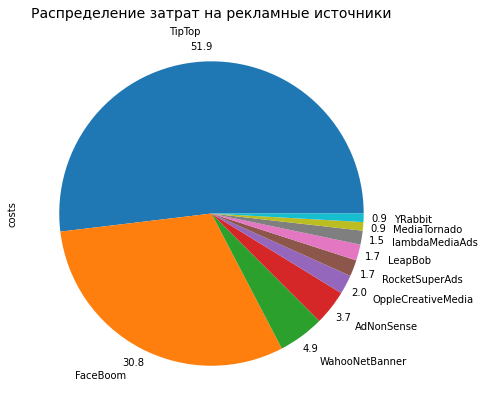

In [26]:
costs.groupby('channel')['costs'].sum().sort_values(ascending=False).plot(kind='pie', 
                                                                          figsize=(10,7), 
                                                                          labeldistance=1.2,
                                                                          autopct='%.1f',
                                                                          pctdistance=1.1,
                                                                          radius=1);
plt.title('Распределение затрат на рекламные источники', fontsize=14, loc='center');

Наибольшая часть рекламного бюджета была потрачена на каналы TipTop (51.9%) и FaceBoom (30.8%). Суммарная доля оставшихся восьми источников не превышает 17% бюджета.

3. Построим визуализацию динамики изменения расходов во времени по каждому источнику:
- по неделям - датафрейм `costs_weekly`
- по месяцам - датафрейм `costs_monthly`

In [27]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs_weekly = pd.pivot_table(costs, 
                              index=costs['dt'].dt.isocalendar().week, 
                              columns='channel', 
                              values='costs', 
                              aggfunc='sum')

costs_monthly = pd.pivot_table(costs, 
                               index=costs['dt'].dt.month, 
                               columns='channel', 
                               values='costs', 
                               aggfunc='sum')

In [28]:
costs_weekly.head()

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
week,,,,,,,,,,
18,211.05,535.7,16.80,38.64,24.00,99.450,347.0,49.2,52.2,81.6
19,273.00,750.2,31.71,61.68,34.50,139.230,470.0,92.4,75.9,103.2
20,265.65,755.7,26.67,59.04,27.50,138.060,454.0,90.0,69.3,90.4
21,266.70,722.7,26.67,50.16,34.25,131.040,801.8,79.2,65.4,119.2
22,202.65,1208.9,65.52,36.96,81.75,97.695,1421.2,179.4,49.8,83.2


In [29]:
costs_monthly

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
dt,,,,,,,,,,
5,1169.70,3524.4,140.28,238.56,169.75,577.980,2981.0,418.8,299.70,458.4
6,538.65,5501.1,314.58,138.00,370.00,325.715,6675.6,921.0,106.20,199.2
7,504.00,5294.3,313.53,138.48,366.50,252.070,8410.2,851.4,97.38,219.2
8,579.60,6274.4,369.81,154.56,439.25,253.110,11202.0,1040.4,124.74,220.0
9,581.70,6114.9,343.98,144.72,427.75,218.400,13232.5,977.4,152.79,247.2
10,537.60,5736.5,315.42,140.16,378.00,205.725,12250.0,942.0,163.41,213.6


Изобразим полученные сводные таблицы на одном графике.

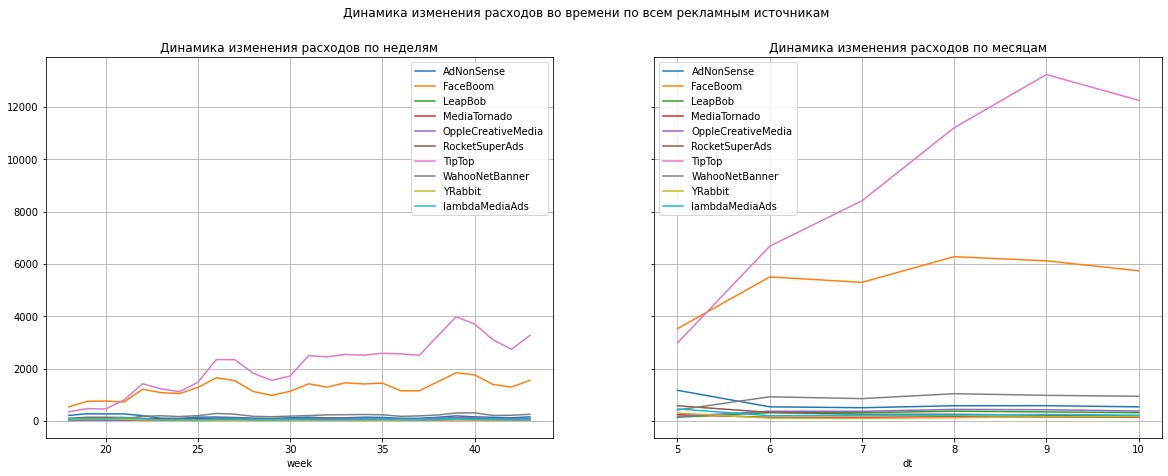

In [30]:
channels = ['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado',
            'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 
            'WahooNetBanner', 'YRabbit', 'lambdaMediaAds']

plt.figure(figsize=(20, 7))

for channel in channels:
    
    ax1 = plt.subplot(1, 2, 1)
    costs_weekly[channel].plot(grid=True, ax=ax1)
    ax1.set_title('Динамика изменения расходов по неделям')
    ax1.legend(channels)

    ax2 = plt.subplot(1, 2, 2, sharey = ax1)
    costs_monthly[channel].plot(grid=True, ax=ax2)
    ax2.set_title('Динамика изменения расходов по месяцам')
    ax2.legend(channels)

plt.suptitle('Динамика изменения расходов во времени по всем рекламным источникам');

Наибольшие рекламные расходы были направлены на TipTop и Faceboom.

Исключим из визуализации рекламные источники `FaceBoom` и `TipTop`, чтобы детальнее рассмотреть более низкие уровни затрат.

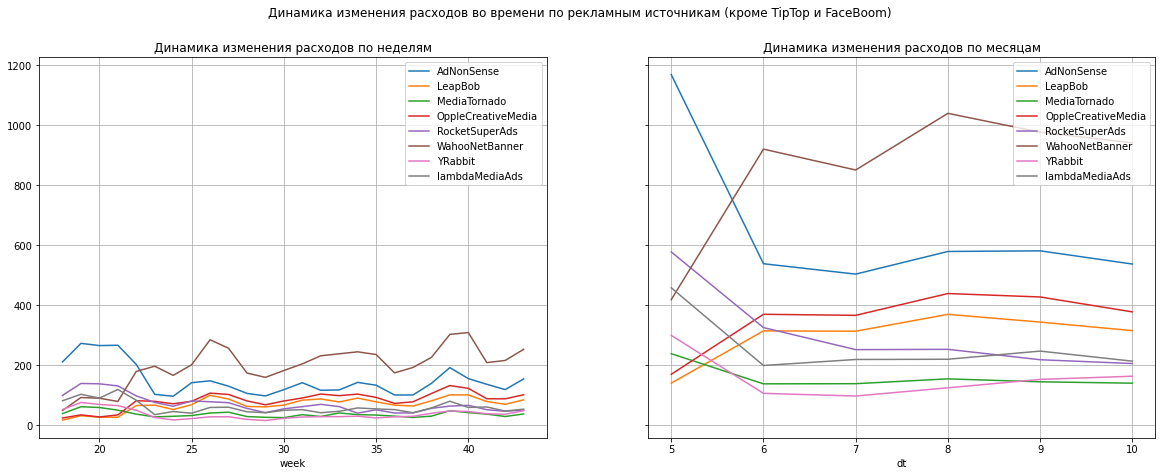

In [31]:
channels = ['AdNonSense', 'LeapBob', 'MediaTornado',
            'OppleCreativeMedia', 'RocketSuperAds', 
            'WahooNetBanner', 'YRabbit', 'lambdaMediaAds']

plt.figure(figsize=(20, 7))

for channel in channels:
    
    ax1 = plt.subplot(1, 2, 1)
    costs_weekly[channel].plot(grid=True, ax=ax1)
    ax1.set_title('Динамика изменения расходов по неделям')
    ax1.legend(channels)

    ax2 = plt.subplot(1, 2, 2, sharey = ax1)
    costs_monthly[channel].plot(grid=True, ax=ax2)
    ax2.set_title('Динамика изменения расходов по месяцам')
    ax2.legend(channels)

plt.suptitle('Динамика изменения расходов во времени по рекламным источникам (кроме TipTop и FaceBoom)');

В остальных рекламных источниках наблюдается схожая динамика расходов.

4. Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Воспользуемся профилями пользователей `profiles`.

In [32]:
profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)

channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
organic               0.000000
Name: acquisition_cost, dtype: float64

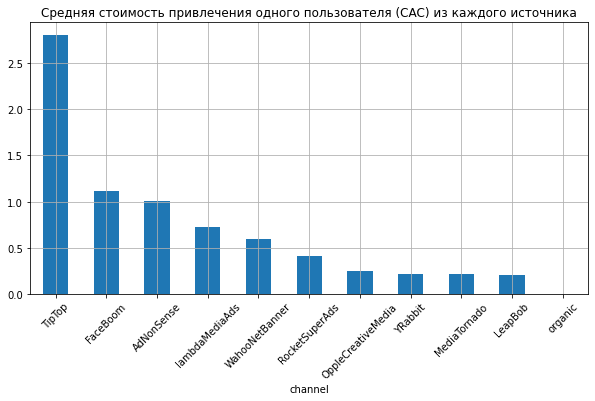

In [33]:
plt.figure(figsize=(10, 5))
profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False).plot(kind='bar', 
                                                                                         grid=True, 
                                                                                         rot=45)
plt.title('Средняя стоимость привлечения одного пользователя (CAC) из каждого источника');

Самое дорогое привлечение пользователей - через канал TipTop.
Самые дешевые рекламные каналы - YRabbit, MediaTornado, LeapBob.

[Назад к содержанию](#table_of_contents)

## Шаг 5. Анализ окупаемости рекламы <a class='anchor' id='step_5'></a>

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Моментом анализа будем считать 1 ноября 2019 года. В бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

1. Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

Определим параметры анализа:
- момент анализа - 1 ноября 2019 г.
- горизонт анализа - 14 дней.

In [34]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

Рассчитаем LTV и ROI, предварительно исключив из `profiles` органических пользователей, поскольку на их привлечение не были затрачены средства рекламного бюджета. 

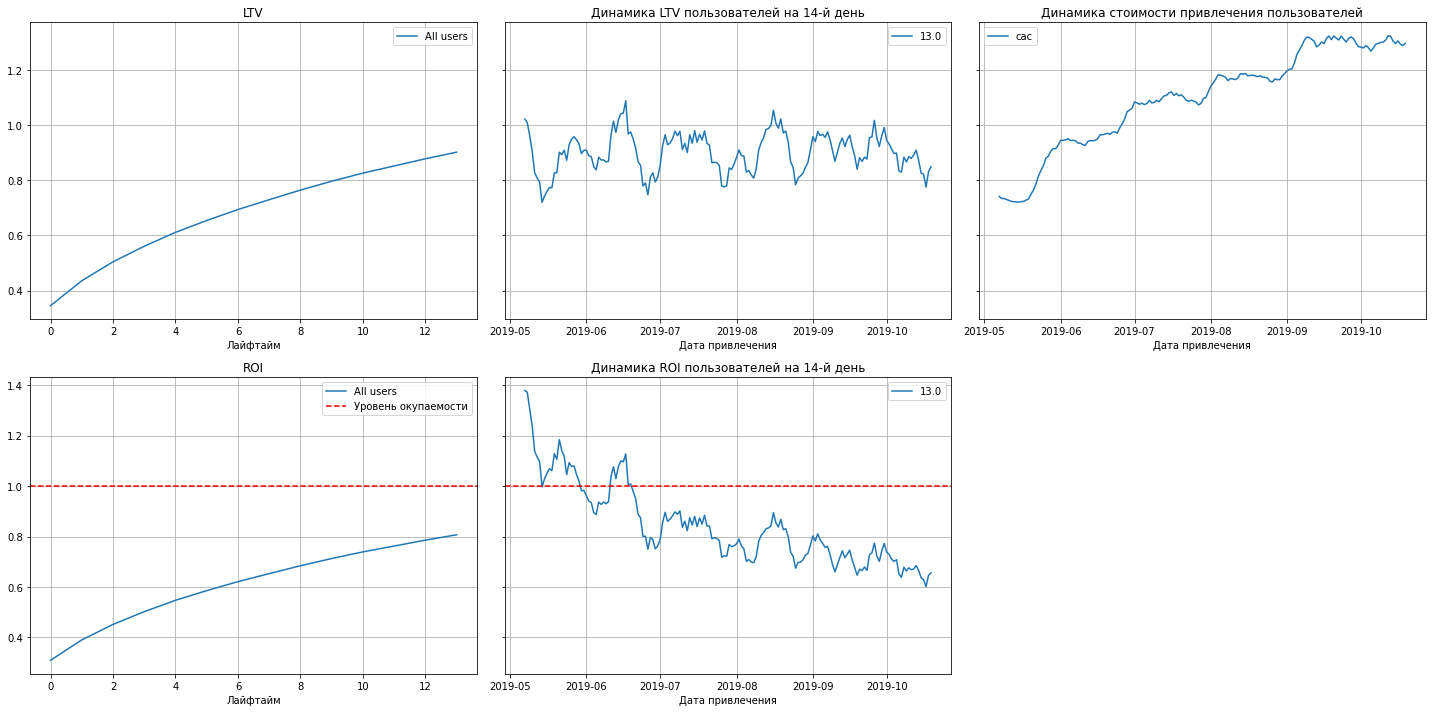

In [35]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

На основе графиков можно сделать следующие выводы:
- Реклама не окупается - ROI не превышает уровня окупаемости, что, вероятно, вызвано увеличением рекламного бюджета.
- Динамика стоимости привлечения пользователей (CAC) показывала постоянный рост рекламных расходов: с уровня 0.8 в мае до 1.2 в октябре.
- Динамика LTV пользователей на 14-й день лайфтайма показывает относительно стабильные колебания на уровне 0.8-1.0 в период с мая по октябрь без характерных проявлений сезонного фактора.
- Динамика ROI свидетельствует о том, что реклама перестала окупаться в конце мая - начале июня.

2. Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

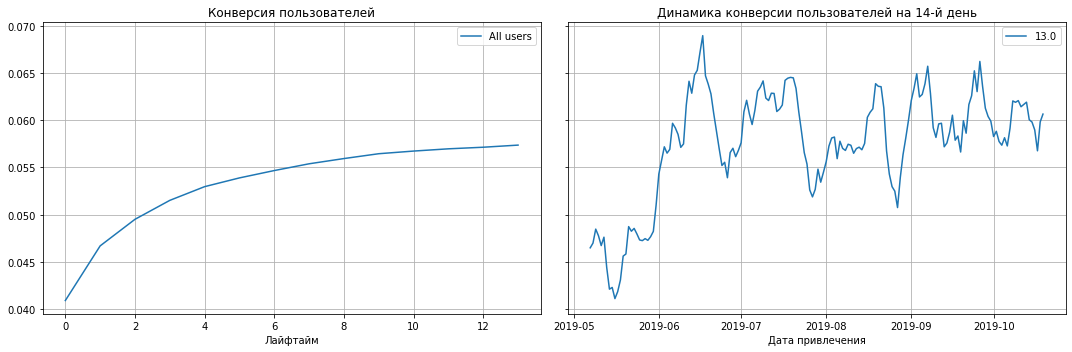

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=[]
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Показатели конверсии стабильны. После двухнедельного срока конверсия составляет более 0.055.

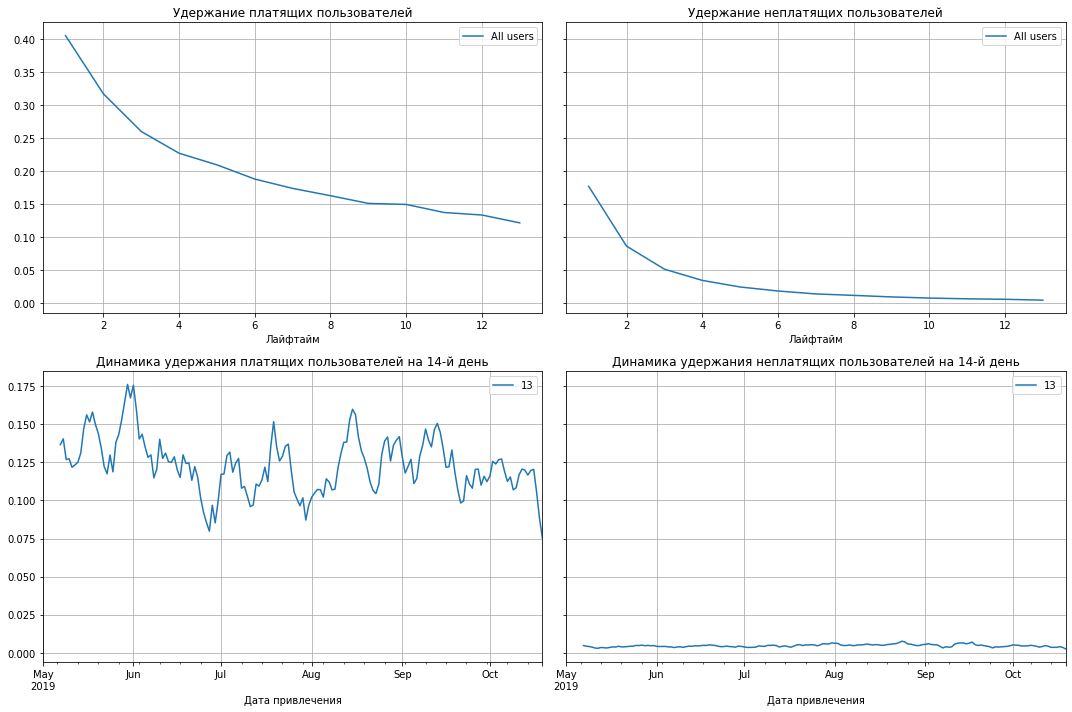

In [37]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=[]
)

plot_retention(retention_grouped, retention_history, horizon_days)

Как видно из графика, неплатящие пользователи удерживаются гораздо хуже, чем платящие, что свидетельствует о верном поведении кривых конверсии.

3. Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

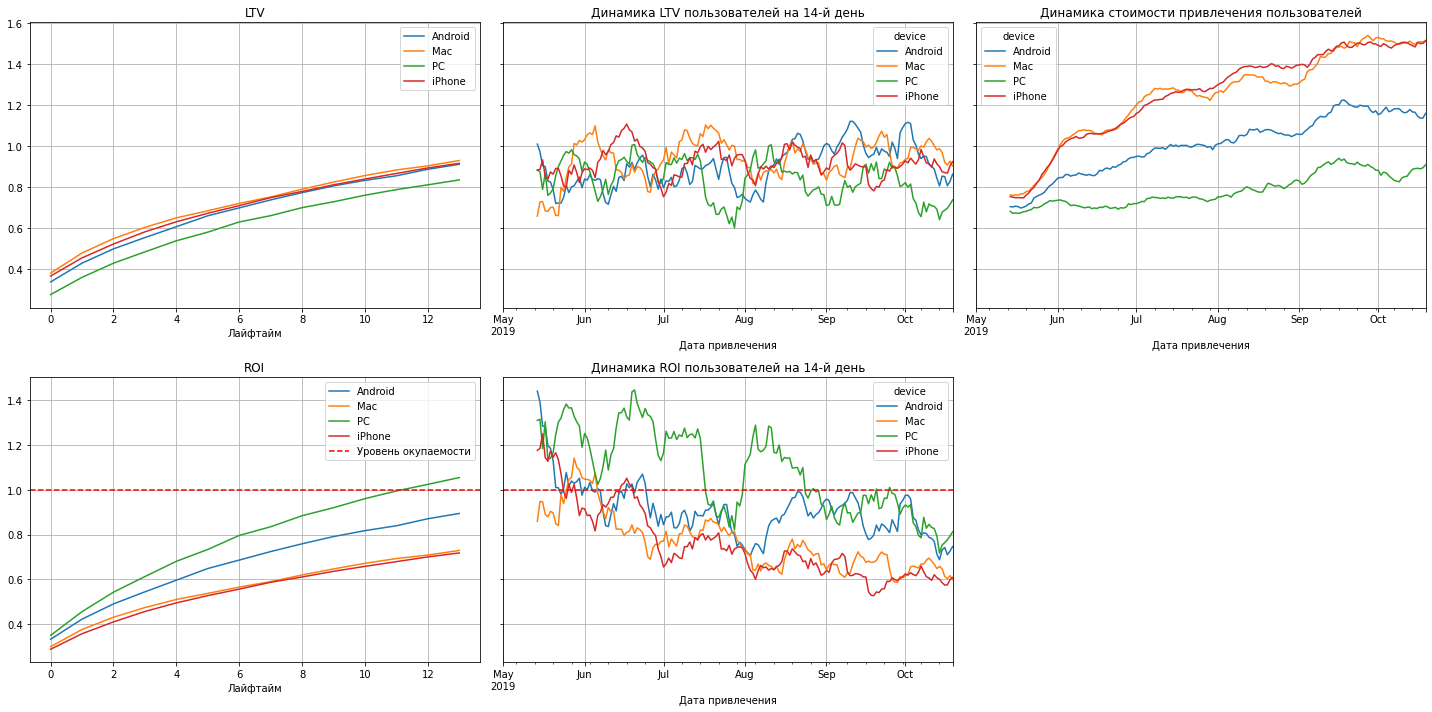

In [38]:
# смотрим окупаемость с разбивкой по устройствам (без органических пользователей)

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

На основе графиков можно сделать следующие выводы:
- Пользователи PC имеют сравнительно меньший LTV, чем все остальные клиенты.
- Реклама окупается только для пользователей PC на 11-й день лайфтайма. Для пользователей Android, Mac, iPhone - реклама не окупается в двухнедельный срок.
- Сильнее всего увеличивался рекламный бюджет для привлечения пользователей Mac и iPhone - с уровня 0.8 в мае до 1.4 в октябре. Меньше всего выросла стоимость привлечения пользователей PC.
- Наибольшую окупаемость рекламы демонстрировали пользователи PC в период с мая по сентябрь. Все остальные пользователи последний раз окупались в мае.

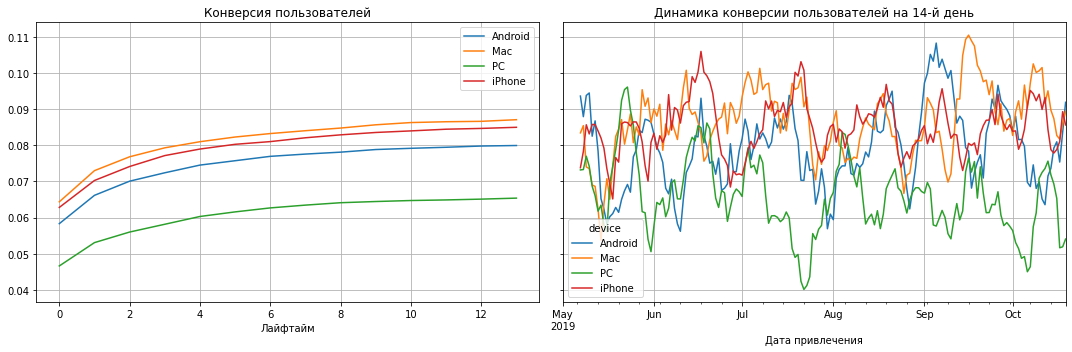

In [39]:
# смотрим конверсию с разбивкой по устройствам (без органических пользователей)

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи PC демонстрируют наиболее низкую конверсию. Возможно, это связано в какими-то техническими проблемами при прохождении этапов покупки. Рассмотрим удержание пользователей в разрезе устройств.

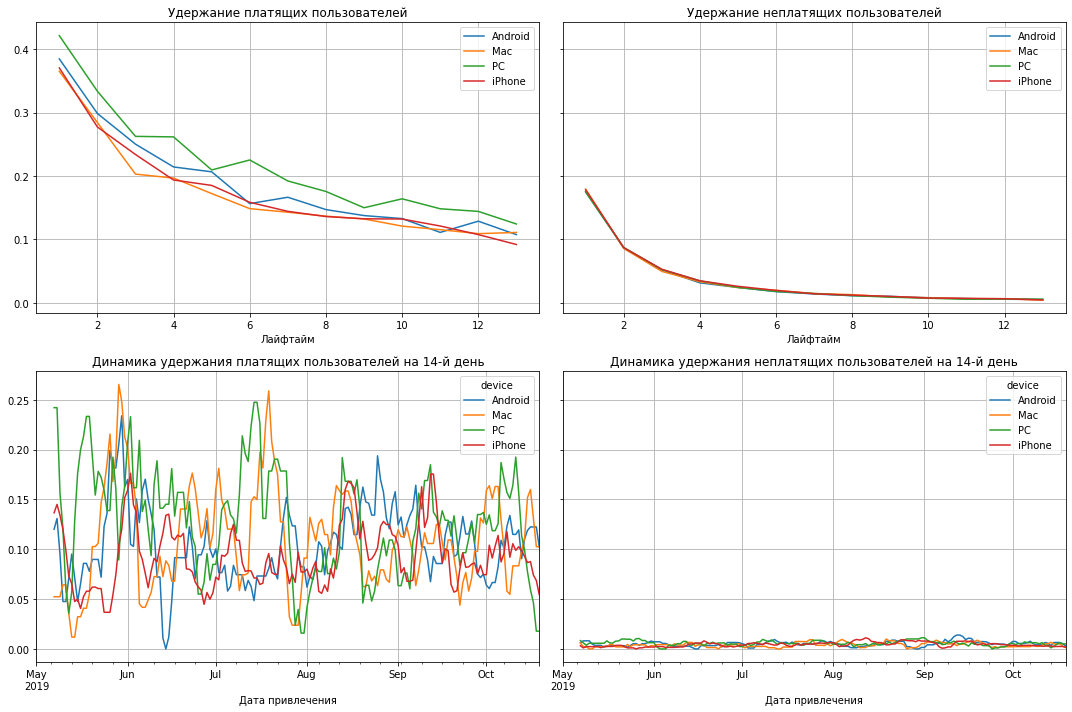

In [40]:
# смотрим удержание с разбивкой по устройствам (без органических пользователей)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles[profiles['channel'] != 'organic'], visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Среди пользователей всех устройств не наблюдается значительных различий в метрике удержания. Это означает, что причина неокупаемости рекламы, скорее всего, связана не с типами устройств привлеченных пользователей, а с другими факторами. 

4. Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

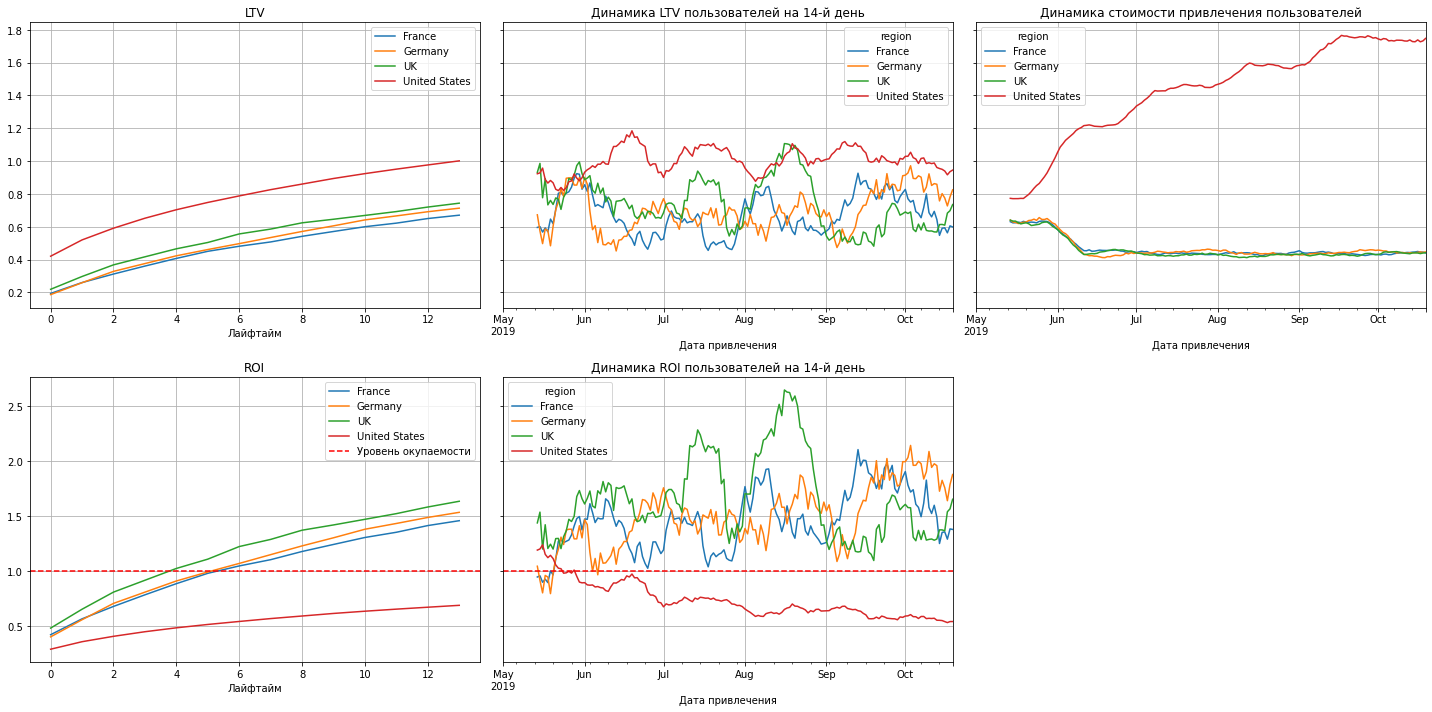

In [41]:
# смотрим окупаемость с разбивкой по странам (без органических пользователей)

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

На основе графиков можно сделать следующие выводы:
- Наибольший уровень LTV показывают пользователи из США, все остальные страны сравнительно на одном уровне.
- Стоимость привлечения пользователей из США является самой дорогой, что также связано с постоянным расширением рекламного бюджета. В июне стоимость привлечения пользователей из Франции, Германии и Великобритании была снижена до стабильного уровня 0.4.
- Реклама в США убыточна весь период с июня по октябрь. Все остальные источники окупаются на 4-5 день лайфтайма и окупались в течение года.

Мы видим, что реклама в США убыточна, но, чтобы понять точную причину неокупаемости, рассмотрим графики конверсии и удержания.

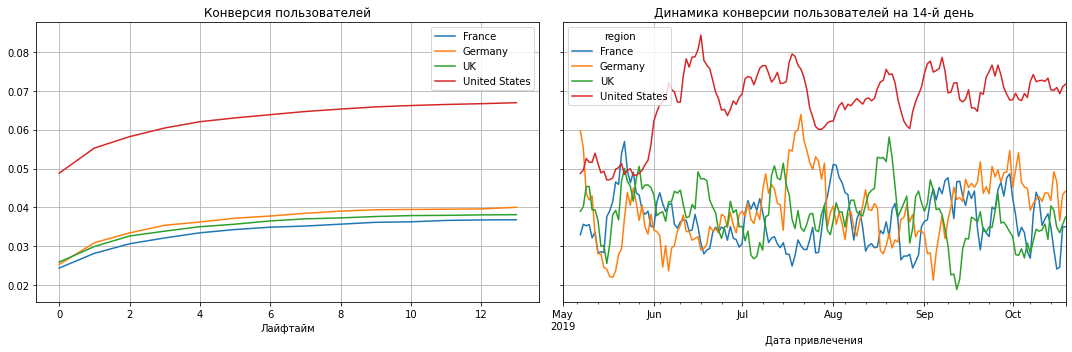

In [42]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

С конверсией пользователей в США нет никаких проблем - она намного лучше, чем во всех остальных регионах. Конверсия остальных стран наблюдается на одном уровне.

Скорее всего, причина неокупаемости рекламы в США кроется в удержании пользователей - посмотрим, так ли это.

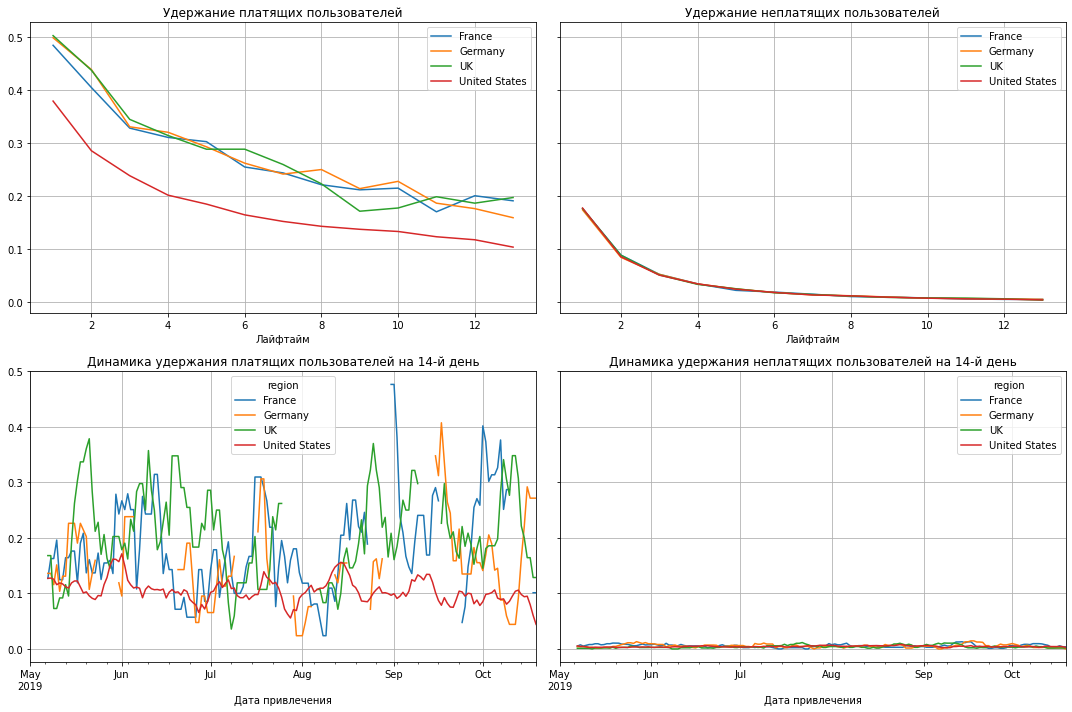

In [43]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Как мы видим, действительно, удержание платящих клиентов в США - самое низкое по сравнению с другими странами. Причина убыточности рекламы - слабое удержание пользователей. Вместо затрат на привлечение новых пользователей из США, следует проводить работу над их удержанием и повышением лояльности.

5. Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

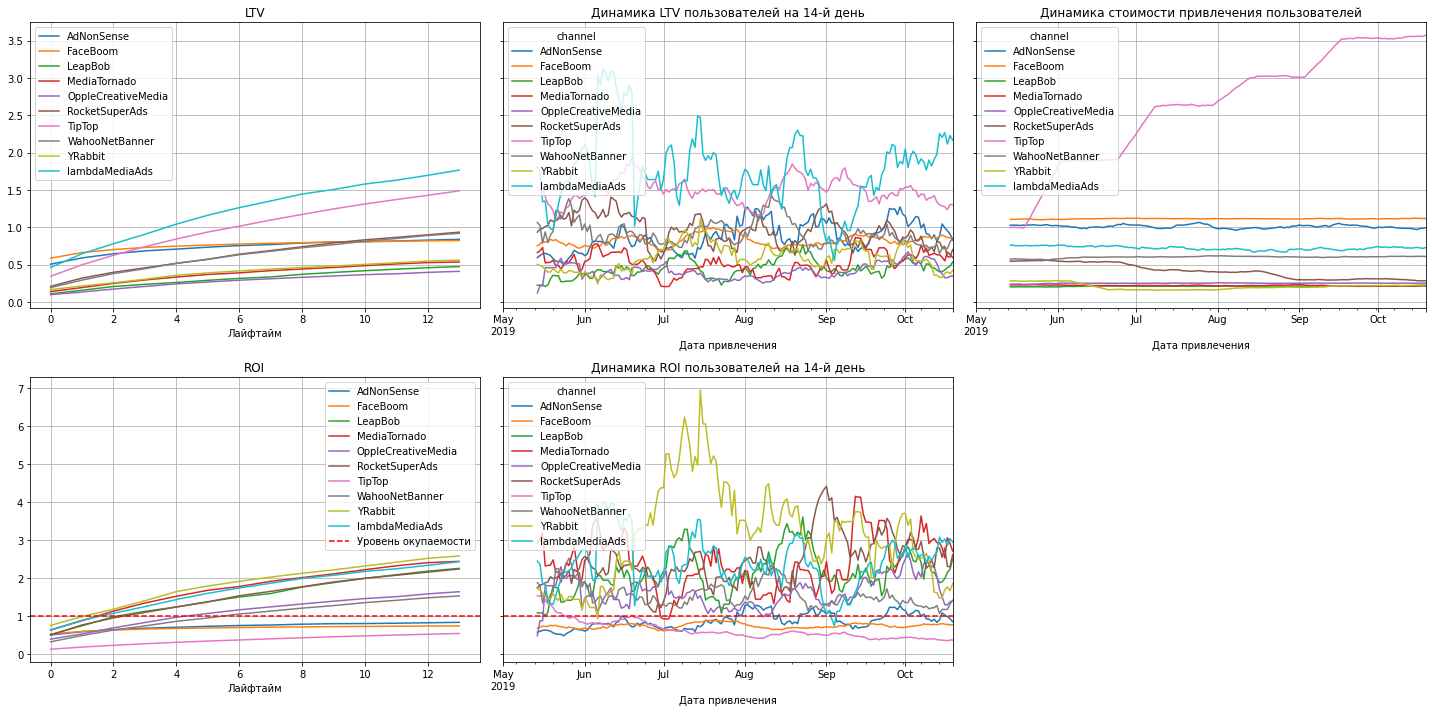

In [44]:
# смотрим окупаемость с разбивкой по рекламным каналам (без органических пользователей)

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

На основе графиков можно сделать следующие выводы:
- Из рекламных источников не окупаются - lambdaMediaAds, Faceboom и TipTop.
- Пользователи, привлеченные через данные три источника - показывают наибольший LTV
- Стоимость привлечения пользователей была стабильна для всех источников, кроме TipTop - его рекламный бюджет постоянно увеличивался с 1.0 в мае до 3.5 в октябре.
- Самую высокую динамику ROI демонстрировал YRabbit в июле.

Чтобы определить точную причину неокупаемости рекламных каналов - рассмотрим их конверсию и удержание пользователей.

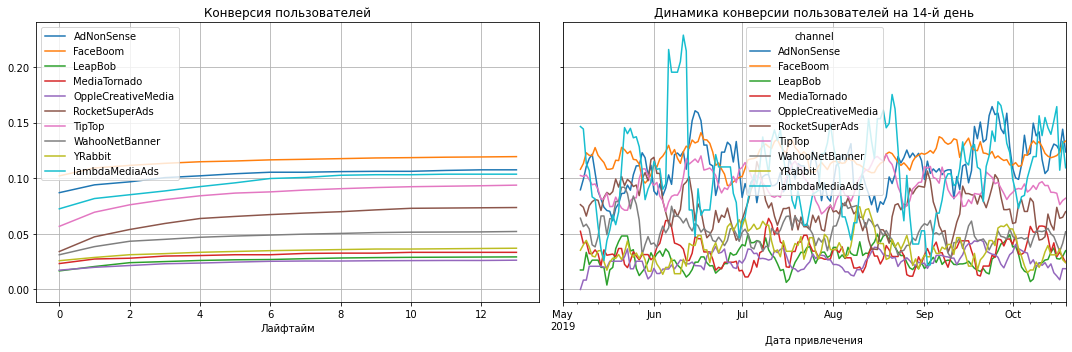

In [45]:
# смотрим конверсию с разбивкой по рекламным каналам (без органических пользователей)

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Убыточные каналы TipTop, Faceboom и lambdaMediaAds имеют высокую, уверенную конверсию на фоне всех источников. Faceboom имеет самую высокую конверсию. Посмотрим, кроется ли причина неокупаемости в удержании этих каналов.

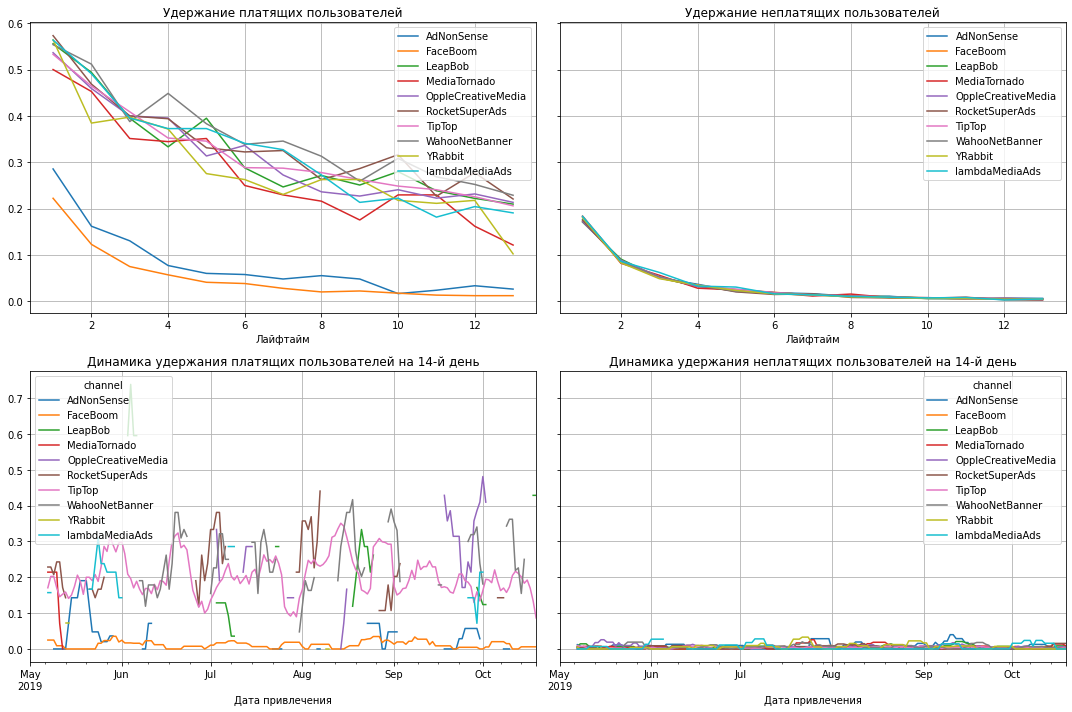

In [46]:
# смотрим удержание с разбивкой по рекламным каналам (без органических пользователей)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles[profiles['channel'] != 'organic'], visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Как мы видим, наихудшее удержание привлеченных пользователей демонстрируют каналы Faceboom и AdNonSense. Чтобы решить проблему убыточности данных каналов, необходимо больше работать над удержанием уже имеющихся клиентов, поскольку эти источники имеют достаточную конверсию. Снижение затрат на привлечение новых пользователей из этих каналов поможет решить проблему неокупаемости рекламы.

[Назад к содержанию](#table_of_contents)

## Выводы <a class='anchor' id='final'></a>

В целом реклама не окупается, поскольку в различных сегментах рекламы имеются достаточно убыточные каналы привлечения.
К наиболее убыточным рекламным каналам, которые ухудшают общую окупаемость, относятся:
- пользователи из США на устройствах iPhone и Mac 
- пользователи мобильных устройств 
- каналы привлечения TipTop, FaceBoom, lambdaMediaAds.

Пользователи из перечисленных каналов демонстрируют хорошие показатели конверсии, удержания и LTV, однако, данные каналы являются дорогими и их привлечение требует больших рекламных бюджетов, от чего реклама теряет окупаемость в целом.
Удержание платящих клиентов в США - самое низкое по сравнению с другими странами. Причина убыточности рекламы - слабое удержание пользователей, которое необходимо повышать. 

Чтобы достигнуть окупаемости общей рекламы рекомендуются следующие меры:
- необходимо больше работать над удержанием уже имеющихся пользователей из Faceboom и AdNonSense, поскольку эти источники имеют достаточную конверсию. Снижение затрат на привлечение новых пользователей из этих каналов поможет решить проблему неокупаемости рекламы.
- уменьшить рекламный бюджет в убыточные источники TipTop, FaceBoom, lambdaMediaAds, OppleCreativeMedia и перенаправить освободившиеся средства на каналы с наибольшим ROI - YRabbit, MediaTornado, RocketSuperAds.
- вместо привлечения новых пользователей из США, следует проводить работу над их удержанием и повышением лояльности.
- уменьшить рекламный бюджет сегмента пользователей iPhone и Mac из США и перенаправить освободившиемся средства на европейские каналы Германии, Франции и Великобритании.
- увеличить рекламный бюджет для пользователей PC и Android.

В процессе исследования были сделаны следующие выводы:

1. Наибольшая доля платящих пользователей наблюдается из США - 6,9%. В США также находится наибольшее суммарное количество пользователей - 100 002. Германия, Великобритания и Франция имеют доля платящих пользователей на уровне 3,8-4,1%.
2. Пользователи используют 4 основных вида устройств входа - Mac, iPhone, Android и PC. Наибольшая доля платящих пользователей принадлежит устройствам Mac - 6,36%, наименьшая - пользователям персональных компьютеров PC - 5,05%. Наибольшее суммарное количество пользователей принадлежит группе пользователей iPhone - более 54 тыс. человек.
3. Наибольшее количество платящих пользователей было привлечено через источник FaceBoom - 12,2%. Данный источник принес более 29 тыс. пользователей суммарно, что является наибольшим результатом после количества органических пользователей.
4. Наихудшие результаты демонстрирует источник OppleCreativeMedia, привлекший лишь 2,7% платящих пользователей.
5. Наибольшее количество суммарных пользователей пришло самостоятельно (источник `organic`) - более 56 тыс. человек, однако, эта группа имеет и самую низкую долю платящих пользователей - 2%.
6. Наименьшее количество пользователей имеет источник lambdaMediaAds - более 2 тыс. человек, тем не менее, источник имеет достачно высокую доля платящих пользователей - 10,47%.
7. Общая сумма расходов на маркетинг составляет 105 497.
8. Наибольшая часть рекламного бюджета была потрачена на каналы TipTop (51.9%) и FaceBoom (30.8%). Суммарная доля оставшихся восьми источников не превышает 17% бюджета.
9. Реклама не окупается - ROI не превышает уровня окупаемости, что, вероятно, вызвано увеличением рекламного бюджета.
10. Динамика стоимости привлечения пользователей (CAC) показывала постоянный рост рекламных расходов: с уровня 0.8 в мае до 1.2 в октябре.
11. Динамика LTV пользователей на 14-й день лайфтайма показывает относительно стабильные колебания на уровне 0.8-1.0 в период с мая по октябрь без характерных проявлений сезонного фактора.
12. Динамика ROI свидетельствует о том, что реклама перестала окупаться в конце мая - начале июня.
13. Показатели конверсии стабильны. После двухнедельного срока конверсия составляет более 0.055.
14. Хуже всего конвертируются пользователи платформы PC по сравнению с другими устройствами.
15. Пользователи PC имеют сравнительно меньший LTV, чем все остальные клиенты.
16. Реклама окупается только для пользователей PC на 11-й день лайфтайма. Для пользователей Android, Mac, iPhone - реклама не окупается в двухнедельный срок.
17. Сильнее всего увеличивался рекламный бюджет для привлечения пользователей Mac и iPhone - с уровня 0.8 в мае до 1.4 в октябре. Меньше всего выросла стоимость привлечения пользователей PC.
18. Наибольшую окупаемость рекламы демонстрировали пользователи PC в период с мая по сентябрь. Все остальные пользователи последний раз окупались в мае.
19. Наибольший уровень LTV показывают пользователи из США, все остальные страны сравнительно на одном уровне.
20. Стоимость привлечения пользователей из США является самой дорогой, что также связано с постоянным расширением рекламного бюджета. В июне стоимость привлечения пользователей из Франции, Германии и Великобритании была снижена до стабильного уровня 0.4.
21. Реклама в США убыточна весь период с июня по октябрь. Все остальные источники окупаются на 4-5 день лайфтайма и окупались в течение года.
22. Из рекламных источников не окупаются - lambdaMediaAds, Faceboom и TipTop.
23. Пользователи, привлеченные через данные три источника - показывают наибольший LTV
24. Стоимость привлечения пользователей была стабильна для всех источников, кроме TipTop - его рекламный бюджет постоянно увеличивался с 1.0 в мае до 3.5 в октябре.
25. Самую высокую динамику ROI демонстрировал YRabbit в июле.

[Назад к содержанию](#table_of_contents)